## 1. Cargamos librerías utiles

In [307]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import haversine as hs
from haversine import Unit

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

from sklearn.linear_model import LinearRegression
from sklearn import tree
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

## 2. Cargamos y transformamos la información de ordenes, productos, shoppers y tiendas

### 2.1. order_products

In [409]:
order_products = pd.read_csv('data/order_products.csv', sep=',')
order_products.head()

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


In [3]:
order_products.isnull().sum()

order_id      0
product_id    0
quantity      0
buy_unit      0
dtype: int64

In [4]:
# Se generan features correspondiente a la cantidad de productos unicos que se pesan o son por unidades
# y la cantidad total (en KG o UN) de cada orden
order_products['prod_KG'] = np.where(order_products['buy_unit'] == 'KG', 1, 0)
order_products['prod_UN'] = np.where(order_products['buy_unit'] == 'UN', 1, 0)
order_products['qty_KG'] = np.where(order_products['buy_unit'] == 'KG', order_products['quantity'], 0)
order_products['qty_UN'] = np.where(order_products['buy_unit'] == 'UN', order_products['quantity'], 0)

order_products = order_products.groupby(['order_id']).sum().reset_index().drop(columns = ['quantity'])

In [5]:
order_products.head()

,order_id,prod_KG,prod_UN,qty_KG,qty_UN
0,0004a3841c1eeb6c6e77585a941c21e0,0,4,0.000,8.0
1,0005a6ecbbde1e8d273f5577bcff2c9c,0,1,0.000,2.0
2,0007baeb6700fc203be2d1f1e11222d7,0,22,0.000,39.0
3,0012195a6a8ca9ec308a3010eeea8ebc,0,11,0.000,13.0
4,0013011fa72b498b9feb84f4e7104980,2,42,1.636,63.0


In [6]:
order_products.shape

(9978, 5)

### 2.2. orders

In [412]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


In [196]:
orders.isnull().sum()

order_id              0
lat                   0
lng                   0
promised_time         0
on_demand             0
shopper_id            0
store_branch_id       0
total_minutes      2000
dtype: int64

In [197]:
# Se generan campos de fecha, hora, dia, mes y dia de semana
orders['fecha_hora'] = orders['promised_time'].apply(lambda x: pd.to_datetime(x.split('+')[0]))
orders['hora'] = orders['fecha_hora'].apply(lambda x: x.hour)
orders['dia'] = orders['fecha_hora'].apply(lambda x: x.day)
orders['mes'] = orders['fecha_hora'].apply(lambda x: x.month)
orders['dia_semana'] = orders['fecha_hora'].apply(lambda x: x.weekday())

In [198]:
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,fecha_hora,hora,dia,mes,dia_semana
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,2019-10-18 20:48:00,20,18,10,4
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,2019-10-19 01:00:00,1,19,10,5
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN,2019-10-19 14:54:00,14,19,10,5
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742,2019-10-18 21:47:00,21,18,10,4
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822,2019-10-19 20:00:00,20,19,10,5


In [200]:
orders[['mes', 'dia']].value_counts()

mes  dia
10   19     7088
     18     2911
     20        1
dtype: int64

Debido a que sólo contamos con 1 observación para el día domingo, codificaremos una nueva variable binaria vie_o_sab
para describir si la orden se realiza el viernes o sabado

In [202]:
orders['vie_o_sab'] = np.where(orders['dia_semana'] == 4, 0, 1) # se codifica el viernes como 0 y sabado como 1

In [203]:
orders['on_demand'] = np.where(orders['on_demand'] == True, 1, 0)

In [204]:
# Sacamos columnas que son irrelevantes para el análisis
orders = orders.drop(columns = ['promised_time', 'fecha_hora', 'dia' ,'mes' ,'dia_semana'])

### 2.3. shoppers

In [411]:
shoppers = pd.read_csv('data/shoppers.csv', sep=',')
shoppers.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


In [17]:
shoppers.shape

(2864, 6)

In [18]:
shoppers.isnull().sum()

shopper_id         0
seniority          0
found_rate       101
picking_speed      0
accepted_rate     27
rating            84
dtype: int64

Debido a la presencia de valores NaN para indicadores de algunos shoppers imputaremos en base a la mediana por
grado de experiencia o seniority

In [19]:
median_kpis_shoppers = shoppers.groupby(['seniority'])[['found_rate', 'picking_speed', 'accepted_rate', 'rating']].median()

In [20]:
shoppers = shoppers.merge(median_kpis_shoppers, how = 'left', on = 'seniority')

In [22]:
shoppers['found_rate'] = np.where(shoppers['found_rate_x'].isnull(), shoppers['found_rate_y'], shoppers['found_rate_x'])
shoppers['picking_speed'] = np.where(shoppers['picking_speed_x'].isnull(), shoppers['picking_speed_y'], shoppers['picking_speed_x'])
shoppers['accepted_rate'] = np.where(shoppers['accepted_rate_x'].isnull(), shoppers['accepted_rate_y'], shoppers['accepted_rate_x'])
shoppers['rating'] = np.where(shoppers['rating_x'].isnull(), shoppers['rating_y'], shoppers['rating_x'])

In [23]:
shoppers = shoppers.drop(columns = ['found_rate_x','picking_speed_x','accepted_rate_x','rating_x','found_rate_y','picking_speed_y','accepted_rate_y','rating_y'])

In [24]:
shoppers.isnull().sum()

shopper_id       0
seniority        0
found_rate       0
picking_speed    0
accepted_rate    0
rating           0
dtype: int64

Re-codificamos la variable seniority con categorías manejables

In [26]:
map_seniority = {
    '6c90661e6d2c7579f5ce337c3391dbb9': 'A',
    '50e13ee63f086c2fe84229348bc91b5b': 'B',
    '41dc7c9e385c4d2b6c1f7836973951bf': 'C', 
    'bb29b8d0d196b5db5a5350e5e3ae2b1f': 'D'
}
shoppers['seniority'] = shoppers['seniority'].map(map_seniority)

In [27]:
shoppers.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,C,0.86060,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,A,0.84460,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,A,0.85590,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,B,0.84765,2.41,0.80,4.88
4,8efbc238660053b19f00ca431144fdae,A,0.87700,1.31,0.92,4.88


### 2.4. stores

In [410]:
storebranch = pd.read_csv('data/storebranch.csv', sep=',')
storebranch.head()

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


In [29]:
storebranch.isnull().sum()

store_branch_id    0
store_id           0
lat                0
lng                0
dtype: int64

In [30]:
storebranch.rename(columns=({'lat':'y_lat', 'lng':'y_lng'}), inplace=True)

## 3. Merge order_products, orders, shopper and storebranch

Consolidamos las 4 fuentes de datos en un solo data frame. Adicionalmente, calculamos la distancia en kilometros entre la ubicación del local y la dirección de entrega del pedido

In [187]:
data = orders.merge(order_products, how='inner', on='order_id')
data = data.merge(shoppers, how='inner', on='shopper_id')
data = data.merge(storebranch, how='inner', on='store_branch_id')

In [188]:
coords = data[['lat','lng','y_lat', 'y_lng']]
data['d1'] = list(zip(coords.lat, coords.lng))
data['d2'] = list(zip(coords.y_lat, coords.y_lng))
data['distance_km'] = data.apply(lambda x: hs.haversine(x['d1'], x['d2'], unit=Unit.KILOMETERS), axis=1)

In [189]:
data = data.drop(columns = ['lat' ,'lng', 'shopper_id', 'store_branch_id', 'store_id', 'y_lat', 'y_lng', 'd1', 'd2'])

In [190]:
dumm1 = pd.get_dummies(data['seniority'], drop_first=True, prefix='seniority')
data = pd.concat([data, dumm1], axis=1)
data.head()

,order_id,on_demand,total_minutes,hora,vie_o_sab,prod_KG,prod_UN,qty_KG,qty_UN,seniority,found_rate,picking_speed,accepted_rate,rating,distance_km,seniority_B,seniority_C,seniority_D
0,e750294655c2c7c34d83cc3181c09de4,1,67.684264,20,0,4,15,2.756,16.0,A,0.9024,1.30,0.92,4.76,1.823027,0,0,0
1,3bb5d9adb3ecac1925b60d5d26a510c4,1,160.336211,16,1,4,30,2.900,63.0,A,0.9024,1.30,0.92,4.76,0.961906,0,0,0
2,b838eea64cf24dde0a78ce1feb84ca7c,0,122.239210,16,1,1,71,1.000,155.0,A,0.8909,1.17,0.96,5.00,1.652017,0,0,0
3,2c85303190a77493348b0b827232f4d6,0,133.113926,19,1,8,72,7.646,115.0,A,0.8462,1.11,0.96,4.96,0.694902,0,0,0
4,e606cc26b843c312df82a29d1f8d4372,0,94.734479,0,1,3,26,2.216,97.0,B,0.8138,1.89,0.84,4.68,3.316288,1,0,0


## 5. Análisis exploratorio

In [206]:
data_plot = data[data.loc[:,'total_minutes'].isnull() == False]

<AxesSubplot:xlabel='total_minutes', ylabel='Count'>

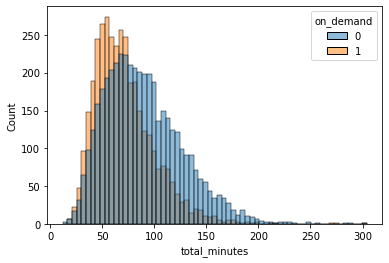

In [229]:
sns.histplot(x='total_minutes', data=data_plot, hue='on_demand')

La distribución del total de minutos presenta valores que escapan del resto, como es de esperarse en este tipo de fenómenos. También se puede notar la diferencia de tiempos entre pedidos on demand y pedidos normales, lo cual nos indica visualmente que existe una relación significativa entre el tipo de orden y el tiempo total de la misma.

<AxesSubplot:xlabel='distance_km', ylabel='total_minutes'>

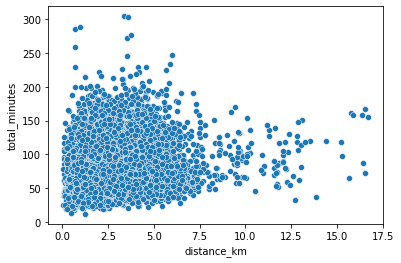

In [227]:
sns.scatterplot(data=data_plot, x='distance_km', y='total_minutes')

Se aprecia una leve correlación positiva entre total_times y distance_km, lo cual es lógico ya que existe una relación directa entre estas dos magnitudes.

<AxesSubplot:xlabel='seniority', ylabel='total_minutes'>

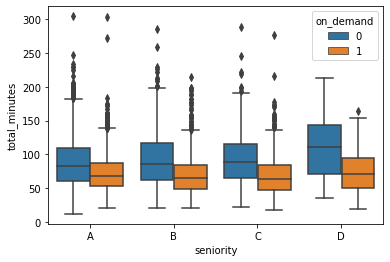

In [230]:
sns.boxplot(x='seniority', y='total_minutes', hue='on_demand', data=data_plot)

In [232]:
data_plot['seniority'].value_counts()/data_plot.shape[0]

A    0.613554
B    0.223224
C    0.150570
D    0.012652
Name: seniority, dtype: float64

Si comparamos total_time por niveles de seniority podremos notar que no se aprecia una gran diferencia entre los distintos niveles a excepción del último (D), pero este efecto es debido a que los shoppers categorizados con este nivel de seniority son varias ordenes de magnitud menores que el resto, llegando a representar cerca del 1% de las ordenes.

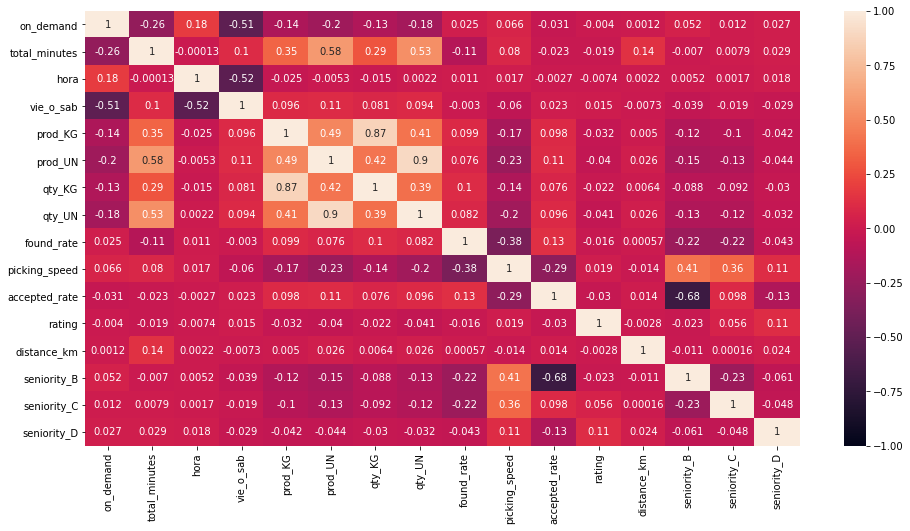

In [233]:
plt.figure(figsize=(16,8))
ax = sns.heatmap(data_plot.corr(), cmap='rocket', vmin=-1, vmax=1, annot=True)

Finalmente, se construye un mapa de calor que representa las correlaciones lineales entre las distintas variables con la finalidad de percibir si es que existe información redundate que permita explicar el tiempo total y que variables aportan más a estimar este tiempo. Si bien se aprecia un efecto de redundancia con algunas de las variables, como por ejemplo con prod_KG/qty_KG y prod_UN/qty_UN, realizaremos una limpieza de estas variables mediante un procedimiento de selección forward, apoyandonos con un modelo de regresión lineal multivariada.

### 6. Variables importantes

In [234]:
X = data.drop(columns=['order_id', 'seniority', 'total_minutes'])
Y = data['total_minutes']

X_vimp = X[Y.isnull() == False]
Y_vimp = Y[Y.isnull() == False]

In [235]:
n_features = X_vimp.shape[1]
estimator = LinearRegression()

sfs = SFS(estimator, #modelo a utilizar para la selección forward
          k_features=n_features, #número de variables a considerar
          forward=True, #tipo de seleccion
          floating=False,
          scoring ='r2',
          cv=5) #particiones de validación cruzada

In [236]:
sfs.fit(X_vimp, Y_vimp)

SequentialFeatureSelector(estimator=LinearRegression(), k_features=15,
                          scoring='r2')

In [239]:
scores = np.zeros(n_features)
for i in range(1, n_features+1):
    scores[i-1] = sfs.get_metric_dict()[i]['avg_score']

<AxesSubplot:>

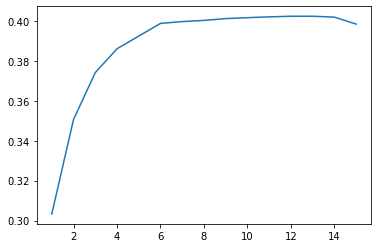

In [407]:
sns.lineplot(x = np.arange(n_features)+1, y=scores)

Agregar más de 9 variables al modelo no pareciera explicar mejor la variabilidad de nuestra variable respuesta, por lo que
consideraremos las 9 variables más importantes.

In [243]:
imp_features = list(sfs.get_metric_dict()[9]['feature_idx'])
imp_features_names = data.drop(columns=['order_id', 'seniority', 'total_minutes']).columns[imp_features]
imp_features_names

Index(['on_demand', 'prod_KG', 'prod_UN', 'found_rate', 'picking_speed',
       'accepted_rate', 'distance_km', 'seniority_B', 'seniority_D'],
      dtype='object')

In [242]:
X = X[imp_features_names]
X.head()

,on_demand,prod_KG,prod_UN,found_rate,picking_speed,accepted_rate,distance_km,seniority_B,seniority_D
0,1,4,15,0.9024,1.30,0.92,1.823027,0,0
1,1,4,30,0.9024,1.30,0.92,0.961906,0,0
2,0,1,71,0.8909,1.17,0.96,1.652017,0,0
3,0,8,72,0.8462,1.11,0.96,0.694902,0,0
4,0,3,26,0.8138,1.89,0.84,3.316288,1,0


## 7. Modelos

### 7.0. Modelo de sobrevivencia
Si bien este tipo de modelos no son los favoritos en cuanto a su nivel predictivo, si son bastante útiles y fáciles de explicar, ya que la interpretación de los coeficientes es intuitiva y a parte permite entender gráficamente el comportamiento del evento en cuestion (en nuestro caso es la entrega del pedido). Para poder utilizar este modelo generaremos una variable para denotar que todos los eventos son observables y consideraremos sólo las variables más importantes obtenidas en la sección anterior.

In [250]:
X_cox = pd.DataFrame(X[Y.isnull() == False], columns=imp_features_names)
X_cox['event'] = 1
X_cox['duration'] = Y[Y.isnull() == False]
X_cox.head()

,on_demand,prod_KG,prod_UN,found_rate,picking_speed,accepted_rate,distance_km,seniority_B,seniority_D,event,duration
0,1,4,15,0.9024,1.30,0.92,1.823027,0,0,1,67.684264
1,1,4,30,0.9024,1.30,0.92,0.961906,0,0,1,160.336211
2,0,1,71,0.8909,1.17,0.96,1.652017,0,0,1,122.239210
3,0,8,72,0.8462,1.11,0.96,0.694902,0,0,1,133.113926
4,0,3,26,0.8138,1.89,0.84,3.316288,1,0,1,94.734479


In [251]:
cph = CoxPHFitter()
cph.fit(X_cox, duration_col='duration', event_col='event')

<lifelines.CoxPHFitter: fitted with 7983 total observations, 0 right-censored observations>

In [252]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7983 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7983
number of events observed = 7983
   partial log-likelihood = -62191.82
         time fit was run = 2021-09-19 15:55:23 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
on_demand       0.34       1.41       0.02             0.30             0.39                 1.35                 1.48
prod_KG        -0.05       0.95       0.01            -0.06            -0.04                 0.94                 0.96
prod_UN        -0.03       0.97       0.00            -0.04            -0.03                 0.97                 0.97
found_rate      3.81      45.34       0.41             3.01             4.62                20.20               101.77
picking_speed  -0.32       0.72       0.02            -0.37            -0.28                 0.69                 0.76
accepted_rate   0.61       1.85       0.17             0.28             0.95                 1.33                 2.57
distance_km    -0.10       0.91       0.01            -0.11            -0.08                 0.90                 0.92
seniority_B     0.13       1.14       0.04             0.06             0.21                 1.06                 1.24
seniority_D    -0.19       0.82       0.11            -0.40             0.01                 0.67                 1.01

                   z      p   -log2(p)
covariate                             
on_demand      14.75 <0.005     161.07
prod_KG        -7.92 <0.005      48.62
prod_UN       -35.70 <0.005     924.86
found_rate      9.25 <0.005      65.21
picking_speed -14.65 <0.005     159.12
accepted_rate   3.63 <0.005      11.78
distance_km   -14.50 <0.005     155.77
seniority_B     3.34 <0.005      10.23
seniority_D    -1.84   0.07       3.92
---
Concordance = 0.73
Partial AIC = 124401.63
log-likelihood ratio test = 3116.81 on 9 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:>

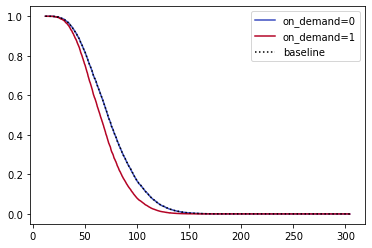

In [58]:
cph.plot_partial_effects_on_outcome(covariates='on_demand', values=[0, 1], cmap='coolwarm')

<AxesSubplot:>

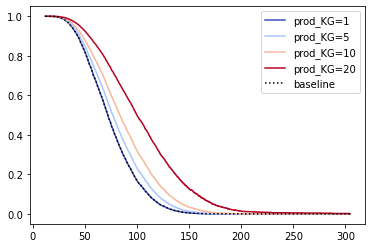

In [256]:
cph.plot_partial_effects_on_outcome(covariates='prod_KG', values=[1, 5, 10, 20], cmap='coolwarm')

<AxesSubplot:>

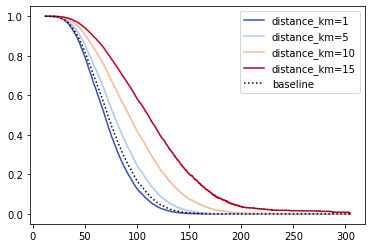

In [257]:
cph.plot_partial_effects_on_outcome(covariates='distance_km', values=[1, 5, 10, 15], cmap='coolwarm')

En cada uno de los gráficos anteriores podemos apreciar el efecto de la covariable sobre la probabilidad de sobrevivencia (u ocurrencia del evento), que para nosotros es la entrega del pedido. Podemos apreciar el efecto de la distancia y como a mayores valores la curva cae mas lento, similar para la covariable prod_KG, donde a mayor cantidad de productos únicos que son pesados la curva cae con mayor lentitud y por lo tanto aumentan los tiempos de entrega.

In [249]:
Y_pred = cph.predict_expectation(X_cox)
cph_model_MAE = mean_absolute_error(Y_pred, X_cox['duration'])
cph_model_RMSE = np.sqrt(mean_squared_error(Y_pred, X_cox['duration']))
print("MAE: ", cph_model_MAE)
print("RMSE: ", cph_model_RMSE)

MAE:  20.990370943727562
RMSE:  29.420609526387842


## 7.1. Escalamos covariables y creamos funciones útiles

In [261]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [262]:
X_models = X[Y.isnull() == False]
Y_models = Y[Y.isnull() == False]
X_final = X[Y.isnull() == True]
Y_final = Y[Y.isnull() == True]

In [295]:
indices = np.arange(X_models.shape[0])

split = train_test_split(indices, test_size=0.3, random_state=42)

X_train = X_models[split[0],:]
X_test = X_models[split[1],:]

Y_train = Y_models.iloc[split[0]].reset_index(drop=True)
Y_test = Y_models.iloc[split[1]].reset_index(drop=True)

In [296]:
def HyperParametersTuning(model, param_list, cov_train, cov_test, label_train, label_test):
    """
    Descripción: Mediante randomized cross-validation search permite ajustar los hiperparámetros de cualquier modelo.
    Además, entrega una lista con los indicadores relacionados al ajuste MAE y RMSE
    
    Parámetros:
    model: Modelo de interés
    param_list: Lista de parámetros correspondiente al modelo
    cov_train: Data frame de entrenamiento que contiene las covariables
    cov_test: Data frame de test que contiene las covariables
    label_train: Data frame de entrenamiento que contiene la variable respuesta
    label_test: Data frame de test que contiene la variable respuesta
    
    Entrega una lista con el MAE y RMSE para el mejor modelo según la lista de parametros ingresada
    """
    
    rsearch = RandomizedSearchCV(model,
                                 param_distributions=param_list, #lista de parámetros
                                 cv=3, #número de particiones de validación cruzada
                                 n_jobs=-2, #número de nucleos
                                 n_iter=100, #número de iteraciones o muestras
                                 verbose=2,
                                 scoring='neg_mean_absolute_error') #scoring de selección
    rsearch.fit(cov_train, label_train)
    
    print(pd.DataFrame.from_dict(rsearch.best_params_, orient='index', columns=['value']))
    
    best_model = rsearch.best_estimator_
    best_model.fit(cov_train, label_train)
    label_pred = best_model.predict(cov_test)
    sns.scatterplot(x=label_test, y=label_pred)
    
    model_MAE = mean_absolute_error(label_pred, label_test)
    model_RMSE = np.sqrt(mean_squared_error(label_pred, label_test))
    print("MAE: ", model_MAE)
    print("RMSE: ", model_RMSE)
    
    indicadores = {
        'MAE': model_MAE,
        'RMSE': model_RMSE
    }
    
    return indicadores

## 7.2. Regresión lineal

In [302]:
lm_model = LinearRegression(fit_intercept=True)

<AxesSubplot:xlabel='total_minutes'>

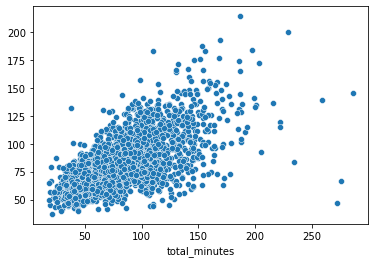

In [303]:
lm_model.fit(X_train, Y_train)
Y_pred = lm_model.predict(X_test)
sns.scatterplot(x=Y_test, y=Y_pred)

In [304]:
lm_model_MAE = mean_absolute_error(Y_pred, Y_test)
lm_model_RMSE = np.sqrt(mean_squared_error(Y_pred, Y_test))
lm_results = {
    'MAE': lm_model_MAE,
    'RMSE': lm_model_RMSE
}
print("MAE: ", lm_model_MAE)
print("RMSE: ", lm_model_RMSE)

MAE:  20.097086712212512
RMSE:  26.536177378101634


## 7.3. XGBoost

Fitting 3 folds for each of 100 candidates, totalling 300 fits
               value
n_estimators    40.0
max_depth        4.0
learning_rate    0.1
MAE:  19.318002898658165
RMSE:  25.762303810446504


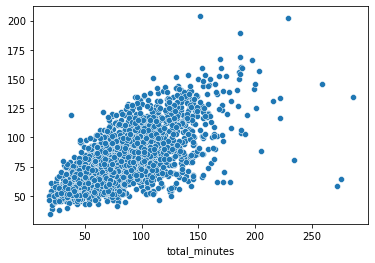

In [317]:
xgb_model = XGBRegressor()

grilla = {'n_estimators': [int(x) for x in np.linspace(start=20, stop=200, num=10)],
         'max_depth': [int(x) for x in np.linspace(start=2, stop=20, num=10)],
         'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.2]}

xgb_results = HyperParametersTuning(model=xgb_model, param_list=grilla, cov_train=X_train, cov_test=X_test, label_train=Y_train, label_test=Y_test)

## 7.4. Árbol de regresión

Fitting 3 folds for each of 100 candidates, totalling 300 fits
                  value
min_samples_split    80
min_samples_leaf    104
max_leaf_nodes      280
max_depth            47
criterion           mae
MAE:  20.147641500372306
RMSE:  27.41023425101304


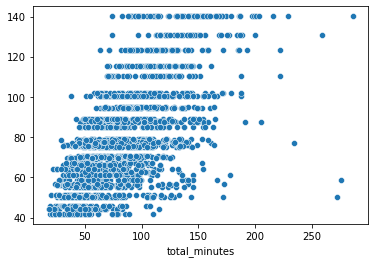

In [297]:
tree_model = tree.DecisionTreeRegressor()

grilla = {'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
          'min_samples_split': [int(x) for x in np.linspace(start=20, stop=400, num=20)],
          'max_depth': [int(x) for x in np.linspace(start=10, stop=100, num=20)],
          'min_samples_leaf': [int(x) for x in np.linspace(start=20, stop=400, num=10)],
          'max_leaf_nodes': [int(x) for x in np.linspace(start=20, stop=400, num=20)]}

tree_results = HyperParametersTuning(model=tree_model, param_list=grilla, cov_train=X_train, cov_test=X_test, label_train=Y_train, label_test=Y_test)

## 7.5. Random Forest Regressor

Fitting 3 folds for each of 100 candidates, totalling 300 fits
                   value
n_estimators         400
min_samples_split     30
min_samples_leaf       2
max_depth             10
MAE:  19.52578422506035
RMSE:  25.863760191038907


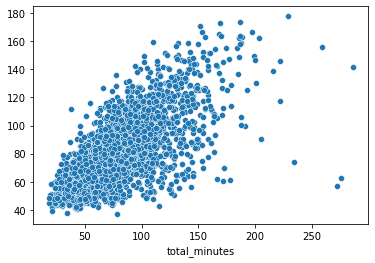

In [298]:
rfr_model = RandomForestRegressor()

grilla = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
          'max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
          'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
          'min_samples_leaf': [1, 2, 4, 10, 20]}

rfr_results = HyperParametersTuning(model=rfr_model, param_list=grilla, cov_train=X_train, cov_test=X_test, label_train=Y_train, label_test=Y_test)

## 7.6. AdaBoost

Fitting 3 folds for each of 100 candidates, totalling 300 fits
                     value
n_estimators          1000
loss           exponential
learning_rate        0.001
MAE:  21.18456790695613
RMSE:  27.60861820743654


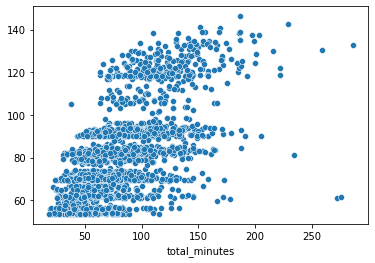

In [299]:
ada_model = AdaBoostRegressor()

grilla = {'n_estimators': [int(x) for x in np.linspace(start=600, stop=2000, num=15)],
          'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5],
          'loss': ['linear','square','exponential']}

ada_results = HyperParametersTuning(model=ada_model, param_list=grilla, cov_train=X_train, cov_test=X_test, label_train=Y_train, label_test=Y_test)

## 7.7. Red neuronal

Fitting 3 folds for each of 100 candidates, totalling 300 fits
                    value
max_iter             1000
hidden_layer_sizes  (20,)
alpha                 0.1
activation           relu
MAE:  19.31490661300511
RMSE:  25.63966558720969


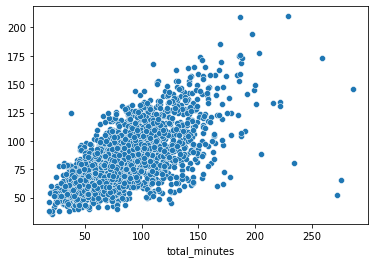

In [300]:
mlpr_model = MLPRegressor()

grilla = {'hidden_layer_sizes':  [(1,),(20,),(40,),(80,),(200,)],
          'alpha': 10.0 ** -np.arange(1, 7),
          'activation': ["identity", "logistic", "tanh", "relu"],
          'max_iter': [1000]}

mlpr_results = HyperParametersTuning(model=mlpr_model, param_list=grilla, cov_train=X_train, cov_test=X_test, label_train=Y_train, label_test=Y_test)

## 7.8. SVR

Fitting 3 folds for each of 100 candidates, totalling 300 fits
       value
kernel   rbf
degree     8
C         20
MAE:  18.813944634161203
RMSE:  26.10942947989774


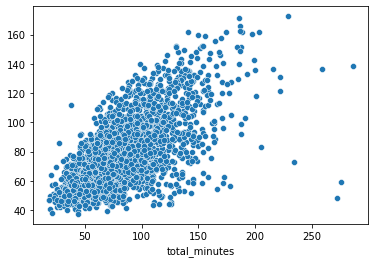

In [301]:
svr_model = SVR()

grilla = {'kernel': ["linear", "poly", "rbf", "sigmoid"],
          'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],
          'C': [1, 5, 10, 20, 30, 40, 50]}

svr_results = HyperParametersTuning(model=svr_model, param_list=grilla, cov_train=X_train, cov_test=X_test, label_train=Y_train, label_test=Y_test)

## 8. Comparación de modelos

In [355]:
def Resultados(model_name, dict_results):
    df = pd.DataFrame(np.array(list(dict_results.values())).reshape(1,-1), columns=['MAE', 'RMSE'])
    df['modelo'] = model_name
    return df

In [365]:
lm_df = Resultados('Linear Regression', lm_results)
xgb_df = Resultados('XGBoost', xgb_results)
tree_df = Resultados('Regression Tree', tree_results)
rfr_df = Resultados('Random Forest', rfr_results)
ada_df = Resultados('Ada Boost', ada_results)
mlpr_df = Resultados('Neural Network', mlpr_results)
svr_df = Resultados('SVR', svr_results)

df_resultados = lm_df.append(xgb_df)
df_resultados = df_resultados.append(tree_df)
df_resultados = df_resultados.append(rfr_df)
df_resultados = df_resultados.append(ada_df)
df_resultados = df_resultados.append(mlpr_df)
df_resultados = df_resultados.append(svr_df)

df_resultados = df_resultados.reset_index(drop=True)
df_resultados

,MAE,RMSE,modelo
0,20.097087,26.536177,Linear Regression
1,19.318003,25.762304,XGBoost
2,20.147642,27.410234,Regression Tree
3,19.525784,25.863760,Random Forest
4,21.184568,27.608618,Ada Boost
5,19.314907,25.639666,Neural Network
6,18.813945,26.109429,SVR


<AxesSubplot:xlabel='MAE', ylabel='RMSE'>

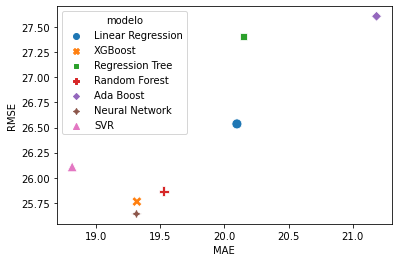

In [376]:
sns.scatterplot(data=df_resultados, x='MAE', y='RMSE', hue='modelo', style='modelo', s=100)

En base a los resultados podemos concluir que los modelos que presentan un mejor ajusta son SVR y la red neuronal. Lo interesante es que si bien la regresión lineal no esta cercano a los mejores modelos, se pueden obtener buenos resultados y una mayor explicabilidad del modelo. De todas maneras, utilizaremos SVR para realizar las predicciones finales en el set de evaluación final.

## 9. Predicciones finales

In [381]:
svr_model = SVR(kernel='rbf',
                degree=8,
                C=20)
svr_model.fit(X_train, Y_train)
final_predictions = svr_model.predict(X_final)

In [404]:
predicted_orders = pd.DataFrame(data.order_id[data.total_minutes.isnull() == True].reset_index(drop=True))
predicted_orders['total_time_prediction'] = final_predictions
predicted_orders.head()

,order_id,total_time_prediction
0,f629881954df817b768c981ad52c56ce,117.161841
1,4d322b65c5ff3c0ab5a68661fe499c33,69.401622
2,7ebab6283d87c169291afd709bd9b4d7,116.395168
3,123bb583303cacd65ae42cd85bdf7694,84.376414
4,f4b7a5bbd3582dc0fe1d85188e792860,51.189606


In [406]:
predicted_orders.to_csv('predicted_orders.csv')